# Model Comparison With Finance Data
This notebook demonstrates how to run the prediction models on financial data

In [5]:
import sys
import os

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [7]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import build_arima_model
from src.models.DL_LSTM import build_lstm_model
from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [8]:
# Stocks / Assets / Indices:
# TSLA – Tesla, Inc.

# BTC-USD – Bitcoin to US Dollar

# BZ=F – Brent Crude Oil Futures

# DX-Y.NYB – U.S. Dollar Index

# %5EVIX – CBOE Volatility Index (VIX)

# %5EGSPC – S&P 500 Index

# PCE Series (Personal Consumption Expenditures):
# PCEPI – PCE Price Index

# PCEPILFE – Core PCE Price Index (Excludes Food & Energy)

# Auto Production Index (FRED: A43REV) – U.S. auto production trends.
# 10-Year Treasury Yield (FRED: DGS10) – Affects growth stock valuations.

# Federal Funds Rate (FRED: FEDFUNDS) – Cost of borrowing; impacts TSLA’s financing.

# Consumer Sentiment Index (FRED: UMCSENT) – High-end car sales are sentiment-driven.
# Consumer Price Index (CPI) - FRED Code: CPIAUCSL
# Semiconductor Index - Ticker: SOXX
# Lithium Prices - Ticker: LIT

# Configuration
FRED_API_KEY = '92300a5052e3ca2facec21726fc18b04'
yahoo_series = ['BTC-USD', 'BZ=F', 'DX-Y.NYB', '%5EVIX', '%5EGSPC', 'LIT', 'SOXX']
fred_series = {'PCEPI': 'PCE_Price_Index', 'PCEPILFE': 'Core_PCE_Price_Index', 'DGS10': '10-Year_Treasury_Yield', 'FEDFUNDS': 'Federal_Funds_Rate', 'UMCSENT': 'University of Michigan: Consumer Sentiment', 'CPALTT01USM657N': 'Consumer Price Index: All Items: Total for United States', 'TOTALSA' : 'Total Vehicle Sales'}
target_ticker = 'TSLA'

scaler = get_scaler()

In [9]:
# Step 1: Load target ticker first to determine date range
df_target = load_finance_data(target_ticker, "1950-01-01", "2024-12-31")
start_date = df_target.index.min().strftime('%Y-%m-%d')
end_date = df_target.index.max().strftime('%Y-%m-%d')
print(f"Target Ticker: {target_ticker}")
print(f"Available Date Range: {start_date} to {end_date}")

# Step 2: Store target data and apply technical features
df_target = enrich_target_stock(df_target, target_ticker)
all_data = {target_ticker: df_target}

# Step 3: Load all other Yahoo Finance tickers aligned to target date range
for ticker in yahoo_series:
    if ticker == target_ticker:
        continue  # already loaded and enriched
    df = load_finance_data(ticker, start_date, end_date)
    all_data[ticker] = df

# Step 4: Load FRED macroeconomic data and align by target's date range
for series_id, series_name in fred_series.items():
    df = load_fred_data(series_id, series_name, FRED_API_KEY, start_date, end_date)
    # Clip to target's date range for clean merge
    df = df.loc[start_date:end_date]
    all_data[series_name] = df


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Target Ticker: TSLA
Available Date Range: 2010-06-29 to 2024-12-30



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
# Combine datasets
combined_data = None
first = True
for name, df in all_data.items():
    df = flatten_cols(df)
    if first:
        combined_data = df
        first = False
    else:
        combined_data = pd.merge(combined_data, df, left_index=True, right_index=True, how='outer')

# Flatten MultiIndex columns (if they exist)
if isinstance(combined_data.columns, pd.MultiIndex):
    combined_data.columns = ['_'.join([str(i) for i in col if i]) for col in combined_data.columns]
else:
    combined_data.columns = [str(col) for col in combined_data.columns]

# Reset and identify date column
combined_data.reset_index(inplace=True)
possible_date_cols = [col for col in combined_data.columns if 'date' in col.lower() or col.lower() == 'index']
if possible_date_cols:
    combined_data.rename(columns={possible_date_cols[0]: 'Date'}, inplace=True)
else:
    raise ValueError("Could not find a date or index column after reset_index.")

# Convert to datetime
combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')

# Drop NA rows before final reset/index
combined_data.dropna(inplace=True)

# Final cleanup: reset index and drop unnamed/index column if exists
combined_data.reset_index(drop=True, inplace=True)

# Now 'Date' is a proper datetime column and not an index (suitable for modeling)
# If you want it as an index for TS modeling, uncomment below:
# combined_data.set_index('Date', inplace=True)

# Clean up any leftover default index column (if exists)
if combined_data.columns[0].lower() in ['index', 'unnamed: 0']:
    combined_data.drop(columns=[combined_data.columns[0]], inplace=True)

# List all feature names
features = combined_data.columns.tolist()

# Print them out
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')

# Extract the target
y = combined_data['Close_TSLA'].values.reshape(-1, 1)  # ensure 2D array

# Initialize and fit RobustScaler
target_scaler = RobustScaler()
y_scaled = target_scaler.fit_transform(y)

# Optional: add it back to the DataFrame if needed
combined_data['Close_TSLA_scaled'] = y_scaled

combined_data.to_csv('../data/dataset_finance/processed/process_finance_data.csv', index=False)    
print("Combined data saved to 'processed_finance_data.csv'")
combined_data


1. Date
2. Open_TSLA
3. High_TSLA
4. Low_TSLA
5. Close_TSLA
6. Volume_TSLA
7. TSLA_Returns
8. TSLA_hour
9. TSLA_day
10. TSLA_month
11. TSLA_weekday
12. TSLA_is_weekend
13. TSLA_RSI
14. TSLA_EMA_12
15. TSLA_EMA_26
16. TSLA_MACD
17. TSLA_MACD_Signal
18. TSLA_SMA_20
19. TSLA_SMA_50
20. TSLA_SMA_200
21. TSLA_Bollinger_Upper
22. TSLA_Bollinger_Lower
23. TSLA_Lag_1
24. TSLA_Lag_2
25. TSLA_Lag_3
26. TSLA_Lag_5
27. TSLA_Lag_10
28. TSLA_Daily_Return
29. TSLA_Total_Return_5d
30. TSLA_Total_Return_10d
31. TSLA_Total_Return_20d
32. Open_BTC-USD
33. High_BTC-USD
34. Low_BTC-USD
35. Close_BTC-USD
36. Volume_BTC-USD
37. BTC-USD_Returns
38. Open_BZ=F
39. High_BZ=F
40. Low_BZ=F
41. Close_BZ=F
42. Volume_BZ=F
43. BZ=F_Returns
44. Open_DX-Y.NYB
45. High_DX-Y.NYB
46. Low_DX-Y.NYB
47. Close_DX-Y.NYB
48. Volume_DX-Y.NYB
49. DX-Y.NYB_Returns
50. Open_%5EVIX
51. High_%5EVIX
52. Low_%5EVIX
53. Close_%5EVIX
54. Volume_%5EVIX
55. %5EVIX_Returns
56. Open_%5EGSPC
57. High_%5EGSPC
58. Low_%5EGSPC
59. Close_%5EGSPC


,Date,Open_TSLA,High_TSLA,Low_TSLA,Close_TSLA,Volume_TSLA,TSLA_Returns,TSLA_hour,TSLA_day,TSLA_month,...,Volume_SOXX,SOXX_Returns,PCE_Price_Index,Core_PCE_Price_Index,10-Year_Treasury_Yield,Federal_Funds_Rate,University of Michigan: Consumer Sentiment,Consumer Price Index: All Items: Total for United States,Total Vehicle Sales,Close_TSLA_scaled
0,2014-09-17,17.493999,17.646667,17.299999,17.425333,77665500.0,0.002454,0.0,17.0,9.0,...,444000.0,0.007185,97.413,96.013,2.62,0.09,84.6,0.075257,16.959,-0.028958
1,2014-09-18,17.557333,17.706667,17.488001,17.587999,55389000.0,0.009335,0.0,18.0,9.0,...,355500.0,0.015285,97.413,96.013,2.63,0.09,84.6,0.075257,16.959,-0.028117
2,2014-09-19,17.199333,17.428667,17.018000,17.288000,102163500.0,-0.017057,0.0,19.0,9.0,...,339000.0,-0.012490,97.413,96.013,2.59,0.09,84.6,0.075257,16.959,-0.029668
3,2014-09-22,17.000000,17.068001,16.313999,16.668667,123211500.0,-0.035824,0.0,22.0,9.0,...,315600.0,-0.012084,97.413,96.013,2.57,0.09,84.6,0.075257,16.959,-0.032871
4,2014-09-23,16.348000,16.920000,16.333332,16.694000,84880500.0,0.001520,0.0,23.0,9.0,...,632700.0,-0.003201,97.413,96.013,2.54,0.09,84.6,0.075257,16.959,-0.032740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,2024-02-26,192.289993,201.779999,192.000000,199.399994,111747100.0,0.038704,0.0,26.0,2.0,...,3759000.0,0.009867,122.494,121.418,4.28,5.33,76.9,0.618967,16.177,0.912051
2374,2024-02-27,204.039993,205.600006,198.259995,199.729996,108645400.0,0.001655,0.0,27.0,2.0,...,4560900.0,-0.000996,122.494,121.418,4.31,5.33,76.9,0.618967,16.177,0.913757
2375,2024-02-28,200.419998,205.300003,198.440002,202.039993,99806200.0,0.011566,0.0,28.0,2.0,...,2923800.0,-0.011244,122.494,121.418,4.27,5.33,76.9,0.618967,16.177,0.925703
2376,2024-02-29,204.179993,205.279999,198.449997,201.880005,85907000.0,-0.000792,0.0,29.0,2.0,...,3382800.0,0.027091,122.494,121.418,4.25,5.33,76.9,0.618967,16.177,0.924875


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set plot style
# sns.set(style='whitegrid')

# # Basic info
# print("Dataset Info:")
# combined_data.info()

# # Summary statistics for numerical variables
# print("\n Descriptive Statistics:")
# print(combined_data.describe().T)

# # For categorical columns
# print("\n Categorical Value Counts:")
# categorical_cols = combined_data.select_dtypes(include='object').columns
# for col in categorical_cols:
#     print(f"\n{col}:\n{combined_data[col].value_counts()}")

# print("\n Missing Values Summary:")
# missing = combined_data.isnull().sum()
# missing = missing[missing > 0].sort_values(ascending=False)
# print(missing)

# # Optional: plot missing values
# if not missing.empty:
#     plt.figure(figsize=(10, 5))
#     sns.barplot(x=missing.values, y=missing.index, palette="viridis")
#     plt.title("Missing Values by Column")
#     plt.xlabel("Count")
#     plt.ylabel("Feature")
#     plt.show()

# # Compute correlations
# numeric_data = combined_data.select_dtypes(include=np.number)
# correlation_matrix = numeric_data.corr()

# # Plot heatmap without annotations, but with colorbar scale
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
# plt.title("Correlation Heatmap", fontsize=14)
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# # Limit to a few columns if too many
# cols_to_plot = numeric_data.columns[:5]  # adjust as needed
# sns.pairplot(combined_data[cols_to_plot].dropna())
# plt.suptitle("Pairplot of Selected Numeric Columns", y=1.02)
# plt.show()

# for col in numeric_data.columns:
#     fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
#     sns.histplot(combined_data[col].dropna(), kde=True, ax=ax[0], color='skyblue')
#     ax[0].set_title(f"Distribution of {col}")
    
#     sns.boxplot(x=combined_data[col], ax=ax[1], color='orange')
#     ax[1].set_title(f"Boxplot of {col}")
    
#     plt.tight_layout()
#     plt.show()


In [ ]:
# # Set correlation threshold (e.g., 0.9 for high correlation)
# threshold = 0.9

# # Compute correlation matrix
# corr_matrix = combined_data.select_dtypes(include=np.number).corr().abs()

# # Get upper triangle of the correlation matrix (excluding self-correlations)
# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # Find features with correlation above threshold
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# print(f"🔍 Features to drop due to multicollinearity (threshold > {threshold}):\n{to_drop}")

# # Drop them from the dataset
# reduced_data = combined_data.drop(columns=to_drop)

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set(style='whitegrid')

# # 1. Identify and Drop Highly Correlated Features
# threshold = 0.9

# numeric_data = combined_data.select_dtypes(include=np.number)
# corr_matrix = numeric_data.corr().abs()
# upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]
# print(f"🔍 Dropping {len(to_drop)} highly correlated features (threshold > {threshold}):\n{to_drop}\n")

# reduced_data = combined_data.drop(columns=to_drop)
# numeric_cols = reduced_data.select_dtypes(include='number').columns

# # 2. Correlation Heatmap After Dropping
# plt.figure(figsize=(10, 8))
# sns.heatmap(reduced_data[numeric_cols].corr(), cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
# plt.title("Correlation Heatmap (After Removing Highly Correlated Features)")
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# # 3. Histograms of Numeric Columns
# for col in numeric_cols:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(reduced_data[col].dropna(), kde=True, color='skyblue')
#     plt.title(f"Distribution of {col}")
#     plt.xlabel(col)
#     plt.ylabel("Frequency")
#     plt.tight_layout()
#     plt.show()

# # 4. Boxplots for Outlier Detection
# for col in numeric_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x=reduced_data[col], color='orange')
#     plt.title(f"Boxplot of {col}")
#     plt.xlabel(col)
#     plt.tight_layout()
#     plt.show()

# # 5. Pairplot of First 4 Numeric Columns
# pairplot_cols = numeric_cols[:4]  # Limit to first 4 for readability
# if len(pairplot_cols) >= 2:
#     sns.pairplot(reduced_data[pairplot_cols].dropna())
#     plt.suptitle("Pairplot of Selected Features", y=1.02)
#     plt.show()
# else:
#     print("Not enough numeric columns for pairplot.")


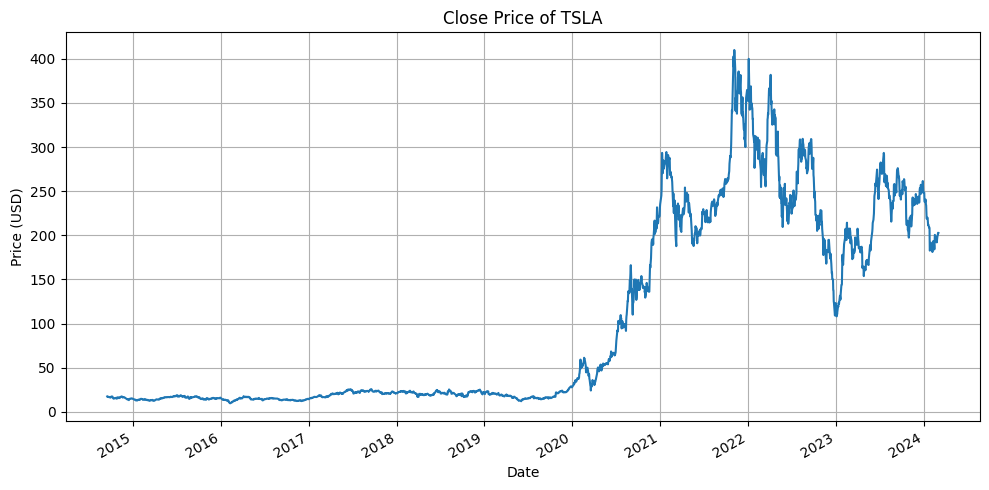

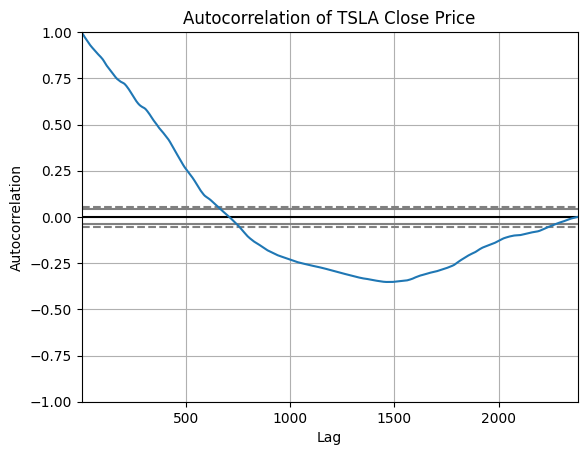

In [11]:
combined_data['Date'] = pd.to_datetime(combined_data['Date'])  # parse as datetime
combined_data.set_index('Date', inplace=True)

combined_data['Close_TSLA'].plot(figsize=(10, 5))
plt.title('Close Price of TSLA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

autocorrelation_plot(combined_data['Close_TSLA'])
plt.title('Autocorrelation of TSLA Close Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [ ]:
order = (5, 1, 0)
predictions, train, test = build_arima_model(combined_data['Close_TSLA'], order, 0.7)

# Convert to numpy arrays (in case they're lists)
test = np.array(test)
predictions = np.array(predictions)

rmse, mae, r2, adj_r2	= generate_model_metrics(predictions, test)

# Root Mean Squared Error
# rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Mean Absolute Error
# mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)

# R-squared
# r2 = r2_score(test, predictions)
print('Test R²: %.3f' % r2)

# Adjusted R-squared
n = len(test)
p = 1  # number of predictors (just 1 for ARIMA by default)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print('Adjusted R²: %.3f' % adj_r2)

# plot forecasts against actual outcomes
plt.plot(test, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend(['Actual', 'Predicted'])
plt.grid(True)
plt.tight_layout()
plt.show()

metrics_scores[name] = {"RMSE": rmse, "MAE": mae, "R2": r2, "Adj_R2": adj_r2}
metrics_df = pd.DataFrame(metrics_scores).T  # Transpose so models are rows
# metrics_df.to_csv("model_metrics_scores.csv")
print(metrics_df)


In [ ]:
# SEQ_LENGTH = 30

# # Get the same Close_Scaled column again
# close_scaled_col = [col for col in combined_data.columns if col.lower().endswith('close_scaled')][0]
# close_prices = combined_data[close_scaled_col].values

# SEQ_LENGTH = 30

# # Prepare the training, validation, and testing datasets
# X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_val_test(combined_data, SEQ_LENGTH)

# print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
# print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
# print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

In [ ]:
# # Step 0: Get TSLA Close Series from combined_data
# tsla_series = combined_data["Close_TSLA"]

# # Step 1: Define models
# models = {
#     "ARIMA": ("ARIMA", tsla_series),
#     "LSTM": build_lstm_model(SEQ_LENGTH)
# }

# # Step 2: Prep
# results = {}
# metrics_scores = {}
# test_dates = tsla_series.iloc[-len(y_test):].index[:100]

# # Step 3: Train + Evaluate
# for name, model in models.items():
#     if name == "ARIMA":
#      			# Split the data into training and testing sets
#         train, test = train_test_split(tsla_series)
#         y_pred = build_arima_model(train, test)
#         y_test_inv = test.values.reshape(-1, 1)
#         y_pred_inv = np.array(y_pred).reshape(-1, 1)
#         test_dates = test.index[:100]
#         p = 1
#     else:
#         model.fit(X_train, y_train, epochs=5, batch_size=32,
#                   validation_data=(X_val, y_val), verbose=0)
#         y_pred = model.predict(X_test)
#         y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
#         y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
#         p = X_test.shape[1]

#     # Metrics
#     n = len(y_test_inv)
#     mae = mean_absolute_error(y_test_inv, y_pred_inv)
#     rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#     r2 = r2_score(y_test_inv, y_pred_inv)
#     r2_adj = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

#     results[name] = (y_test_inv, y_pred_inv)
#     metrics_scores[name] = {"MAE": mae, "RMSE": rmse, "R2": r2, "Adj_R2": r2_adj}

#     # Plot
#     plt.figure(figsize=(10, 4))
#     plt.plot(test_dates, y_test_inv[:100], label=f"{name} True")
#     plt.plot(test_dates, y_pred_inv[:100], label=f"{name} Predicted", linestyle="--")
#     plt.legend()
#     plt.title(f"{name} Model Predictions (First 100 Days)")
#     plt.xlabel("Date")
#     plt.ylabel("Price (USD)")
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

#     print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, Adj R2: {r2_adj:.4f}")


In [ ]:
# # Linear regression as baseline
# from src.data.split_sequences import create_sequences
# close_col = [col for col in combined_data.columns if col.lower().endswith('close_scaled')][0]
# close_prices = combined_data[close_col].values
# X_lr_all, y_lr_all = create_sequences(close_prices, SEQ_LENGTH)
# X_lr = X_lr_all.reshape((X_lr_all.shape[0], X_lr_all.shape[1]))
# X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr_all, test_size=0.2, shuffle=False)
# lr_model = LinearRegression().fit(X_train_lr, y_train_lr)
# mae, y_test_inv, y_pred_inv = evaluate_model(lr_model, X_test_lr, y_test_lr, scaler, is_linear=True)
# results["LinearRegression"] = (y_test_inv, y_pred_inv)
# mae_scores["LinearRegression"] = mae
# print(f"LinearRegression MAE: {mae:.4f}")


In [ ]:
# from statsmodels.tsa.arima.model import ARIMA

# # 1. Extract a univariate series from combined_data
# tsla_col = [col for col in combined_data.columns if col.lower().endswith('close_scaled')][0]
# tsla_series = combined_data[tsla_col]

# # 2. Check stationarity (visual inspection or use ADF test)
# tsla_diff = tsla_series.diff().dropna()

# # Optional: ADF test
# from statsmodels.tsa.stattools import adfuller
# adf_result = adfuller(tsla_diff)
# print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

# # 3. Fit ARIMA (p,d,q)
# model = ARIMA(tsla_series, order=(5, 1, 0))  # Example (5,1,0); adjust with AIC/BIC
# model_fit = model.fit()
# print(model_fit.summary())

# # 4. Forecast the next 30 steps
# forecast_steps = 30
# forecast = model_fit.forecast(steps=forecast_steps)

# # 5. Plot forecast vs actual
# plt.figure(figsize=(12, 6))
# plt.plot(tsla_series[-100:], label="Recent TSLA Scaled Close")
# plt.plot(pd.date_range(start=tsla_series.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label="ARIMA Forecast", linestyle='--')
# plt.title("ARIMA Forecast of TSLA Close (Scaled)")
# plt.legend()
# plt.tight_layout()
# plt.show()



In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(mae_scores.keys(), mae_scores.values())
plt.title("Model Comparison - MAE (Unscaled Prices)")
plt.ylabel("Mean Absolute Error (USD)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
